#### Import Librarie 

In [ ]:
%pip install pytse_client

In [183]:
import pytse_client as tse
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
from torch import nn

from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Get data

In [ ]:
raw_data = tse.download_financial_indexes(symbols=["شاخص كل", "شاخص كل (هم وزن)"], write_to_csv=True, base_path="data")

In [ ]:
data = {'total':[], 'equal weight':[], 'date':[], 'label':[]}
previouse_value = 0
for i in range(min(raw_data["شاخص كل"].shape[0], raw_data["شاخص كل (هم وزن)"].shape[0])):
    row1 = raw_data["شاخص كل"].iloc[i]
    if (row1['date']==raw_data["شاخص كل (هم وزن)"]['date']).sum():
        data['total'].append(row1['value'])
        data['equal weight'].append(float(raw_data["شاخص كل (هم وزن)"][raw_data["شاخص كل (هم وزن)"]['date']==row1['date']]['value']))
        data['date'].append(row1['date'])
        # data['label'].append((-1)**(previouse_value>float(row1['value'])))
        data['label'].append(int(previouse_value<float(row1['value'])))
        previouse_value = float(row1['value'])
data = pd.DataFrame.from_dict(data)
print(data.shape)
data.head()

(833, 4)


,total,equal weight,date,label
0,79015.4,10000.0,2014-03-19,1
1,79013.5,10033.6,2014-03-25,0
2,78619.4,9998.3,2014-03-26,0
3,78239.7,9984.4,2014-03-29,0
4,78469.2,10055.5,2014-03-30,1


<AxesSubplot: >

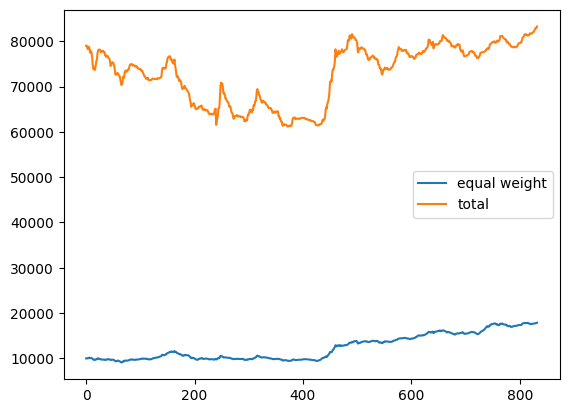

In [185]:
data[['equal weight', 'total']].plot()

#### Prepare data: Data windowing 

In [186]:
class StockDataset(Dataset):
    def __init__(self, data, N, data_type):
        self.data = data
        total, equal_weight, labels = self.windowing(N)
        n_data = len(total)
        if data_type == 'train':
            start, end = 0, int(n_data*0.7)
        elif data_type == 'val':
            start, end = int(n_data*0.7), int(n_data*0.8)
        else:
            start, end = int(n_data*0.8), n_data
        self.total, self.equal_weight, self.labels = total[start:end], equal_weight[start:end], labels[start:end]
        self.total,  self.equal_weight,  self.labels = self.shuffle_data(self.total, self.equal_weight, self.labels)

    def windowing(self, N):
        rolled_data = self.data.rolling(window=N+1)
        total, equal_weight, labels = [], [], []
        for w in rolled_data:
            if w.shape[0]<N+1:
                continue
            w_total = w['total'].iloc[:-1]
            total.append(((w_total-min(w_total))/(max(w_total)-min(w_total)+1)*100).astype(int).tolist())
            w_equal = w['equal weight'].iloc[:-1]
            equal_weight.append(((w_equal-min(w_equal))/(max(w_equal)-min(w_equal)+1)*100).astype(int).tolist())
            
            labels.append(w['label'].tolist()[-1])
        return total, equal_weight, labels
    
    def shuffle_data(self, total, equal_weight, labels):
        data = list(zip(total, equal_weight, labels))
        np.random.shuffle(data)
        total, equal_weight, labels = zip(*data)
        return np.array(total), np.array(equal_weight), np.array(labels)

    def __len__(self):
        return len(self.total)

    def __getitem__(self, idx):
        return self.total[idx], self.equal_weight[idx], self.labels[idx]

In [187]:
train_dataset = StockDataset(data, 50, 'train')
val_dataset = StockDataset(data, 50, 'val')
test_dataset = StockDataset(data, 50, 'test')

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Time series using RNN model

##### RNN Model

In [188]:
class RNNModel(nn.Module):
    def __init__(self, data_dim, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = 128
        self.n_layer = 1
        self.embedding = nn.Embedding(100, 128)
        self.BN = nn.BatchNorm1d(data_dim)
        self.rnn1 = nn.RNN(
            input_size=128,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layer,
            batch_first=True
        )     
        self.rnn2 = nn.RNN(
            input_size=128,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layer,
            batch_first=True
        )     
        self.linear = nn.Linear(in_features=self.hidden_dim*2, out_features=1)

    def forward(self, input1, input2):
        input1 = self.embedding(input1)
        input2 = self.embedding(input2)
        # rnn_hidden = torch.zeros(self.n_layer, input1.shape[0], self.hidden_dim).to(self.device)
        _, hidden1 = self.rnn1(self.BN(input1))
        _, hidden2 = self.rnn2(self.BN(input2))
        hidden = torch.cat([hidden1.sum(axis=0), hidden2.sum(axis=0)], 1)
        out = self.linear(hidden).flatten()
        return out

##### Train RNN model

In [189]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, device, data_type):
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []     
    val_loss, val_acc = 0, 0
    for epoch in range(num_epochs):
        train_bar = tqdm(train_dataloader)
        train_predicted = []
        train_labels = []
        train_acc_list = []
        train_losses = []
        for iter, data in enumerate(train_bar):
            model.train()
            input1, input2, labels = data
            input1 = torch.as_tensor(input1).to(data_type).to(device)
            input2 = torch.as_tensor(input2).to(data_type).to(device)
            labels = torch.as_tensor(labels).to(torch.float32).to(device)
            outputs = model(input1, input2)
            outputs = outputs.flatten()
            predicted = torch.round(nn.Sigmoid()(outputs))
            train_predicted.extend(predicted.to(int).tolist())
            train_labels.extend(labels.tolist())
            train_acc_list.extend((predicted==labels).to(int).tolist())
            optimizer.zero_grad()
            train_loss = loss_function(outputs, labels)
            train_losses.append(train_loss.item())
            train_loss.backward()
            optimizer.step()
            train_acc = sum(train_acc_list)/len(train_acc_list)
            train_loss = sum(train_losses)/len(train_losses)
            if iter == len(train_dataloader)-1:
                val_labels = []
                val_predicted = []
                val_acc_list = []
                val_losses = []
                model.eval()
                for val_iter, data in enumerate(val_dataloader):
                    input1, input2, labels = data
                    input1 = torch.as_tensor(input1).to(data_type).to(device)
                    input2 = torch.as_tensor(input2).to(data_type).to(device)
                    labels = torch.as_tensor(labels).to(torch.float32).to(device)
                    outputs = model(input1, input2)
                    outputs = outputs.flatten()
                    predicted = torch.round(nn.Sigmoid()(outputs))
                    val_predicted.extend(predicted.to(int).tolist())
                    val_labels.extend(labels.tolist())
                    val_acc_list.extend((predicted==labels).to(int).tolist())
                    val_loss = loss_function(outputs, labels)
                    val_losses.append(val_loss.item())
                val_acc = sum(val_acc_list)/len(val_acc_list)
                val_loss = sum(val_losses)/len(val_losses)

                all_train_loss.append(train_loss)
                all_train_acc.append(train_acc)
                all_val_loss.append(val_loss)
                all_val_acc.append(val_acc)
                val_confusion_mat = metrics.confusion_matrix(val_labels, val_predicted)

            train_bar.set_postfix({'train loss': train_loss, 'train acc': train_acc, 'val loss': val_loss, 'val acc': val_acc})
            train_bar.set_description('epoch {}'.format(epoch))
            train_confusion_mat = metrics.confusion_matrix(train_labels, train_predicted)
    return model, all_train_loss, all_train_acc, all_val_loss, all_val_acc, train_confusion_mat, val_confusion_mat

def test_model(model, test_dataloader, device, data_type):
    model.eval()
    loss_function = nn.BCEWithLogitsLoss()
    test_predicted = []
    test_labels = []
    test_losses = []
    test_acc_list = []
    for iter, data in enumerate(test_dataloader):
        input1, input2, labels = data
        input1 = torch.as_tensor(input1).to(data_type).to(device)
        input2 = torch.as_tensor(input2).to(data_type).to(device)
        labels = torch.as_tensor(labels).to(torch.float32).to(device)
        outputs = model(input1, input2)
        outputs = outputs.flatten()
        predicted = torch.round(nn.Sigmoid()(outputs))
        test_predicted.extend(predicted.to(int).tolist())
        test_labels.extend(labels.tolist())
        test_acc_list.extend((predicted==labels).to(int).tolist())
        test_loss = loss_function(outputs, labels)
        test_losses.append(test_loss.item())
    test_loss = sum(test_losses)/len(test_losses)
    test_acc = sum(test_acc_list)/len(test_acc_list)
    confusion_mat = metrics.confusion_matrix(test_labels, test_predicted)
    return test_loss, test_acc, confusion_mat

def plot_test_info(test_loss, test_acc, confusion_mat):
    print('test loss: ' + str(test_loss))
    print('test accuracy: ' + str(test_acc))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in test data')
    plt.show()
    
def plot_train_info(train_loss, train_acc, val_loss, val_acc, train_confusion_mat, val_confusion_mat):
    figure, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].plot(train_loss, label='train loss')
    axis[0].plot(val_loss, label='val loss')
    axis[0].set_title("train and validation loss")
    axis[0].set_xlabel("per 100 iterations")
    axis[0].set_ylabel("loss")
    handles, labels = axis[0].get_legend_handles_labels()
    axis[0].legend(handles, labels)

    axis[1].plot(train_acc, label='train accuracy')
    axis[1].plot(val_acc, label='val accuracy')
    axis[1].set_title("train and validation accuracy")
    axis[1].set_xlabel("per 100 iterations")
    axis[1].set_ylabel("accuracy")
    handles, labels = axis[1].get_legend_handles_labels()
    axis[1].legend(handles, labels)

    plt.tight_layout()
    plt.show()

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in train data')
    plt.show()
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in validation data')
    plt.show()

epoch 99: 100%|██████████| 9/9 [00:00<00:00, 57.84it/s, train loss=0.189, train acc=0.96, val loss=1.06, val acc=0.487]  


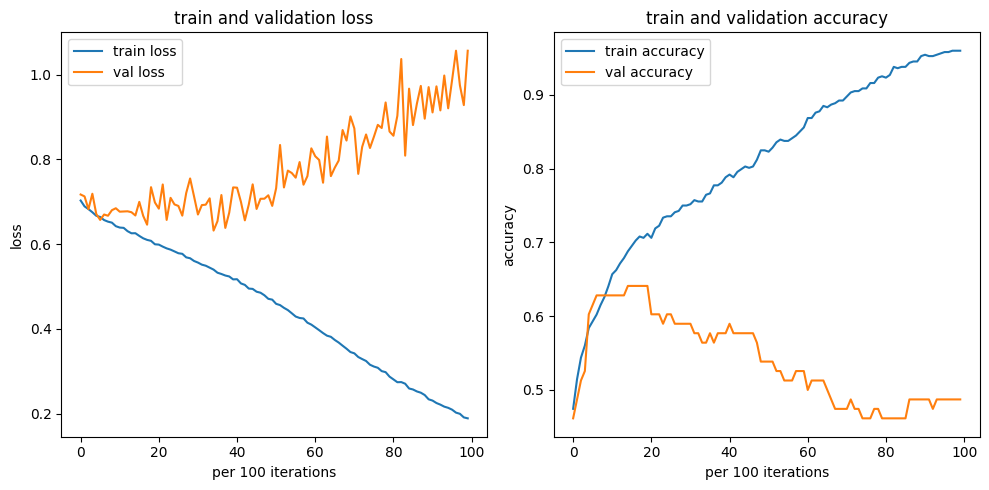

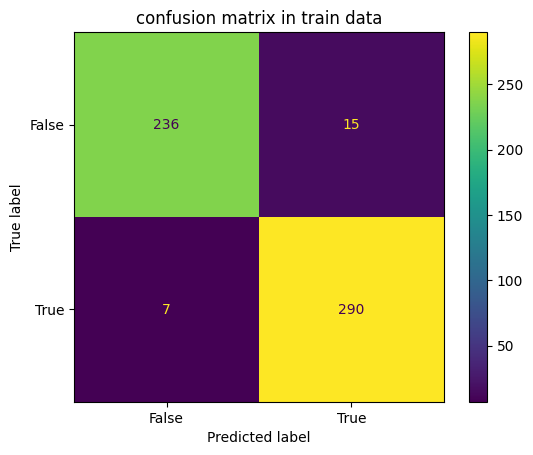

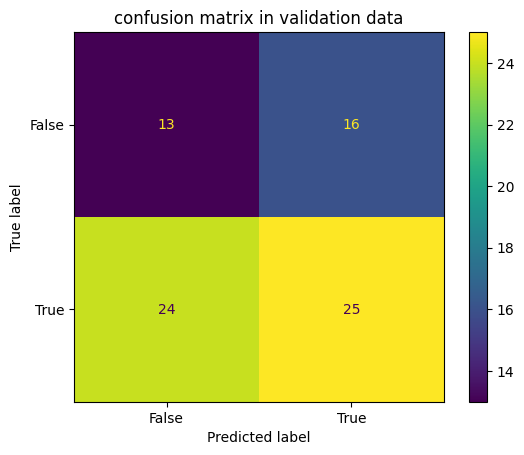

In [192]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rnn_model = RNNModel(train_dataset.total.shape[1], device).to(device)

rnn_model, train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat = train_model(rnn_model, train_dataloader, val_dataloader, 100, device, torch.int)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat)

epoch 19: 100%|██████████| 9/9 [00:00<00:00, 59.27it/s, train loss=0.591, train acc=0.741, val loss=0.663, val acc=0.641]


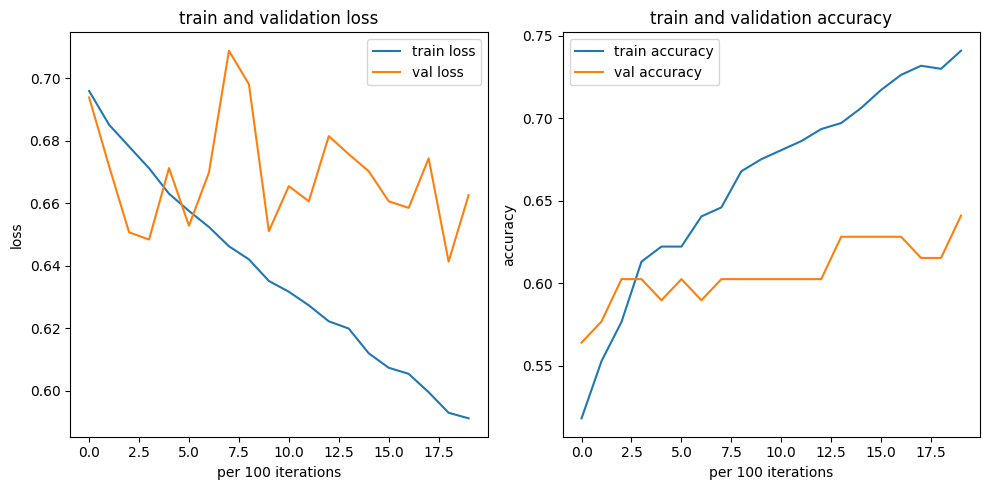

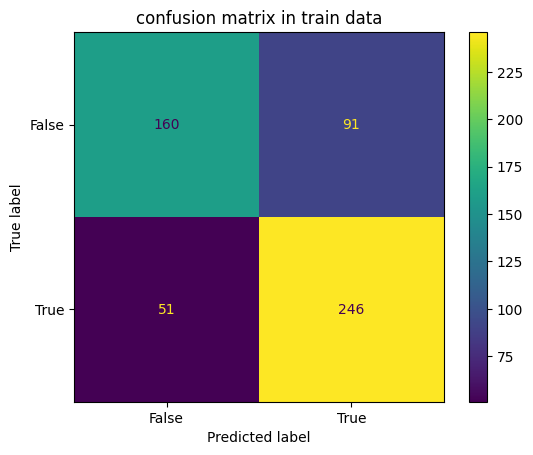

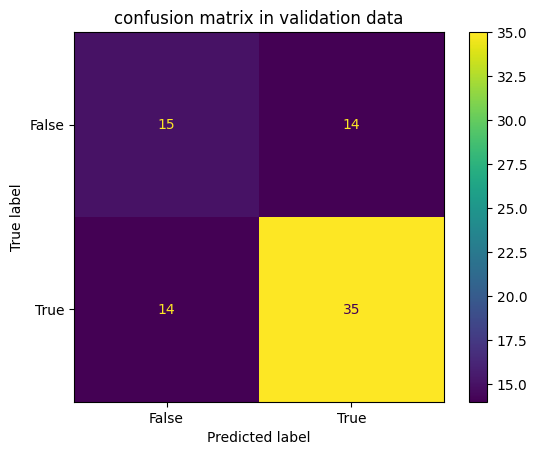

In [204]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rnn_model = RNNModel(train_dataset.total.shape[1], device).to(device)

rnn_model, train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat = train_model(rnn_model, train_dataloader, val_dataloader, 20, device, torch.int)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat)

##### Test RNN model

test loss: 0.6640115976333618
test accuracy: 0.6242038216560509


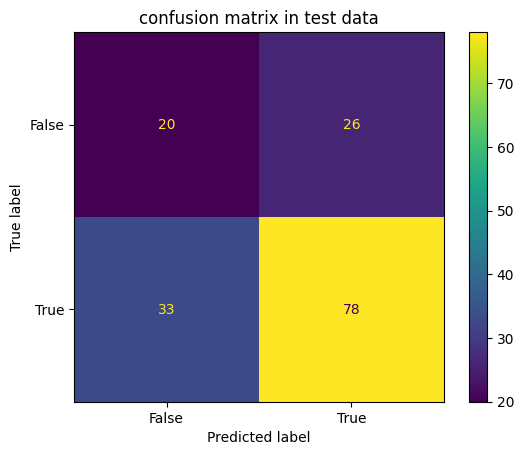

In [205]:
test_loss, test_acc, confusion_mat = test_model(rnn_model, test_dataloader, device, torch.int)
plot_test_info(test_loss, test_acc, confusion_mat)

#### Time series using Convolutional model

##### CNN model

In [209]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (2,5))
        self.BN1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(8, 64, (1,5))
        self.BN2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, (1,5))
        self.BN3 = nn.BatchNorm2d(128)
        self.linear = nn.Linear(in_features=3*128, out_features=1)

    def forward(self, input1, input2):
        input1 = input1.unsqueeze(1)
        input2 = input2.unsqueeze(1)
        x = torch.cat([input1, input2], 1)
        x = x.unsqueeze(1)
        x = F.relu(self.BN1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.BN2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.BN3(self.conv3(x)))
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        out = self.linear(x).flatten()
        return out

##### Train CNN model

epoch 99: 100%|██████████| 9/9 [00:00<00:00, 66.84it/s, train loss=0.408, train acc=0.85, val loss=0.728, val acc=0.538] 


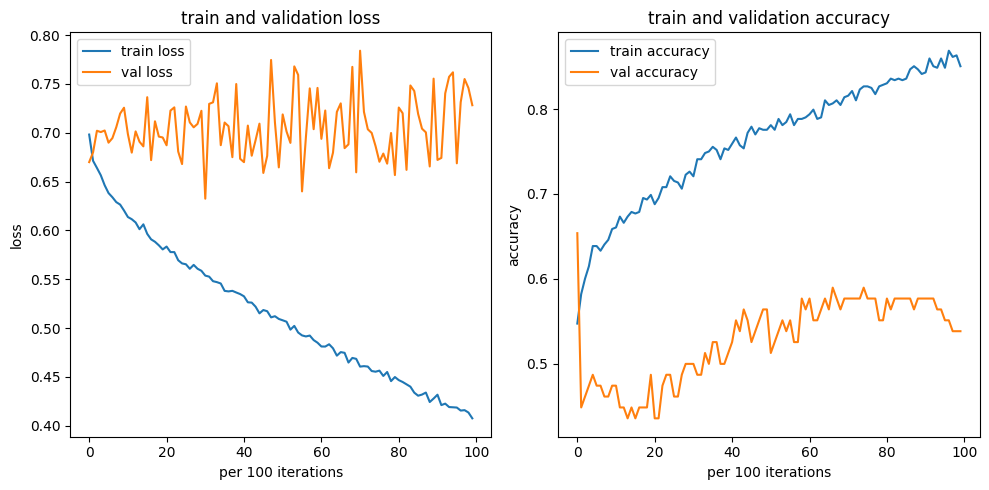

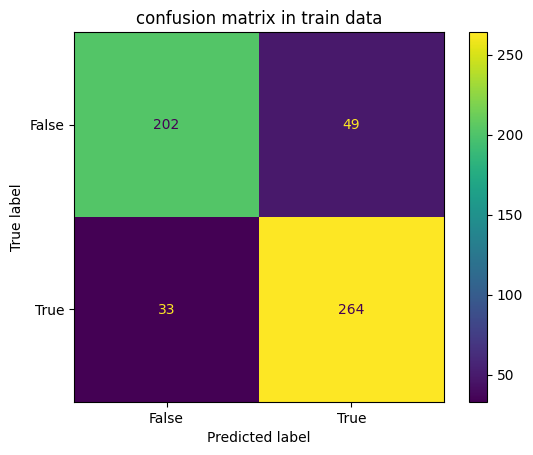

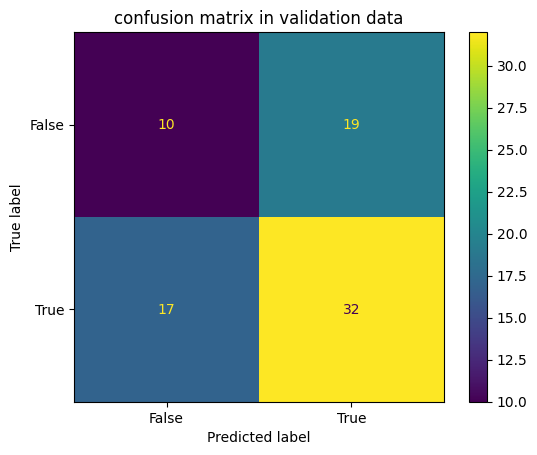

In [162]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
cnn_model = CNNModel().to(device)

cnn_model, train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat = train_model(cnn_model, train_dataloader, val_dataloader, 100, device, torch.float32)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat)

epoch 39: 100%|██████████| 9/9 [00:00<00:00, 66.02it/s, train loss=0.506, train acc=0.786, val loss=0.661, val acc=0.513]


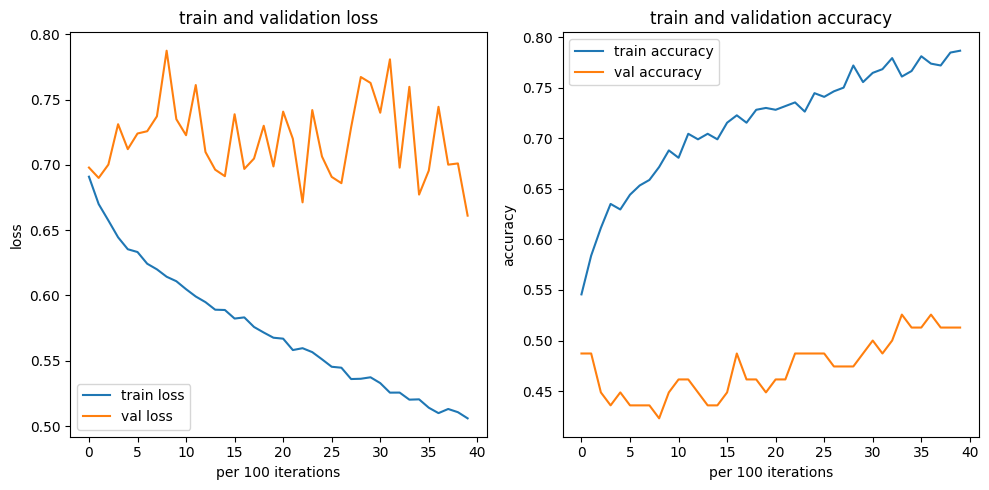

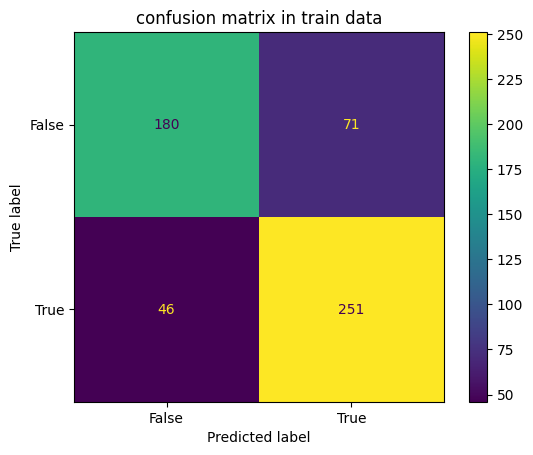

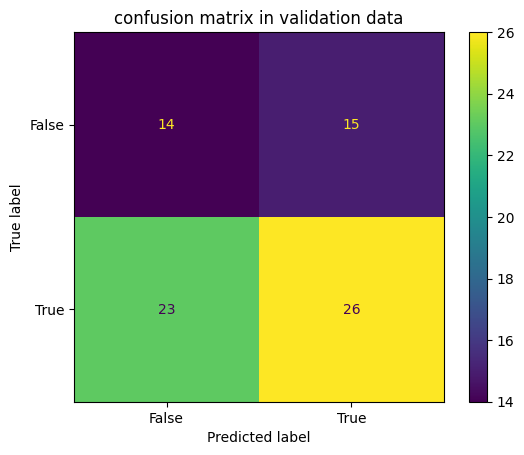

In [212]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
cnn_model = CNNModel().to(device)
cnn_model, train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat = train_model(cnn_model, train_dataloader, val_dataloader, 40, device, torch.float32)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat)

##### Test CNN model

test loss: 0.6515926718711853
test accuracy: 0.6050955414012739


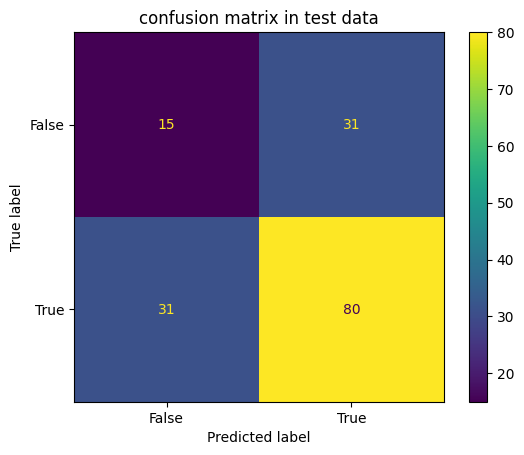

In [213]:
test_loss, test_acc, confusion_mat = test_model(cnn_model, test_dataloader, device, torch.float32)
plot_test_info(test_loss, test_acc, confusion_mat)